# Goal:
Create a time-series  model that predicts the average tax assessment in 2020, given the data from 2010-2019. The 2020 predictions will be used to predict the true 2020 <b>market-value</b> of each house. 

In [1]:
import sys,os,math,string,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from pyzillow.pyzillow import ZillowWrapper, GetDeepSearchResults
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import ensemble, tree, linear_model
import seaborn as sns
import scipy.stats as st
import missingno as msno
import pickle
pd.options.display.max_rows = 200

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics, cross_validation
pd.plotting.register_matplotlib_converters()

%matplotlib inline 

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
#Load Data
df = pd.read_csv("../downsized_6.csv");
df.columns

Index(['Unnamed: 0', 'key', 'PID', 'ST_NUM', 'ST_NAME', 'ST_NAME_SUF',
       'ZIPCODE', 'PTYPE', 'LU', 'OWN_OCC', 'AV_BLDG', 'AV_TOTAL', 'GROSS_TAX',
       'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'LIVING_AREA',
       'NUM_FLOORS', 'R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN', 'R_TOTAL_RMS',
       'R_BDRMS', 'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE', 'R_KITCH',
       'R_KITCH_STYLE', 'R_HEAT_TYP', 'R_AC', 'R_FPLACE', 'R_EXT_CND',
       'R_OVRALL_CND', 'R_INT_CND', 'R_INT_FIN', 'R_VIEW', 'FULLADD',
       'R_TOTAL_BTH', 'MARKET_VALUE', 'DIFF_MV', 'DIFF_TAX', 'Lattitude',
       'Longitude', 'LatLon', 'DIS0', 'DIS1', 'DIS2', 'DIS3', 'DIS4', 'DIS5'],
      dtype='object')

In [3]:
# Dropping all the Na-values!
df = df.dropna(subset=["ZIPCODE","AV_TOTAL"])

# Make-sure zipcodes are numeric, not string
df["ZIPCODE"] = pd.to_numeric(df["ZIPCODE"], errors='ignore')  #df["ZIPCODE"].str.isnumeric(); 

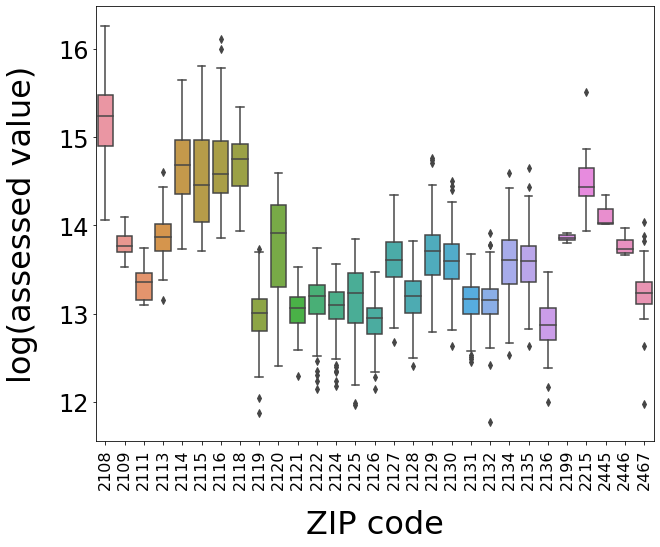

In [4]:
# Plot Zipcode vs Tax - show variation in tax (proxy of market-value) for each area, as a base-line!
df["LOG_AV_TOTAL"] = np.log(df.AV_TOTAL.values)
plt.figure(figsize=(10,8))
ax = sns.boxplot(x="ZIPCODE", y="LOG_AV_TOTAL", data=df[df["key"]==2019])
plt.xticks(rotation=90)

plt.xticks(size=16)
plt.yticks(size=24)
plt.xlabel("ZIP code",size=32,labelpad=20)
plt.ylabel("log(assessed value)",size=32,labelpad=20)

#plt.xlim(left=-0.5e6,right=0.5e6)
plt.xticks(rotation=90)
plt.savefig("Zipcode_TAX_EDA.png",bbox_inches="tight",dpi=300)
plt.show()

Above plot show geographical variation in mean-tax-assessed value of the house for 2019, where each ZIP code has a different mean. Usint the mean as the input feature will provide a goegraphical base-line. In addition, Each mean should vary in time. 

In [5]:
# Groupby year (key) and zipcode, and average over the total tax-assessment for each zipcode-year pair. 
newdfAVG = df.groupby(by=["key","ZIPCODE"])["AV_TOTAL"].mean().unstack(level=1)
newdfAVG

ZIPCODE,2108,2109,2111,2113,2114,2115,2116,2118,2119,2120,...,2131,2132,2134,2135,2136,2199,2215,2445,2446,2467
key,,,,,,,,,,,,,,,,,,,,,
2010,2.636731e+06,632153.928571,366840.000000,6.307397e+05,1.415430e+06,1.250518e+06,1.358740e+06,1.250060e+06,275818.074074,4.738289e+05,...,340428.717949,367117.616580,459941.402174,463875.287179,287110.471698,5.886333e+05,1.163105e+06,7.447667e+05,511733.333333,420182.064935
2011,2.776186e+06,625829.642857,363373.333333,6.327391e+05,1.483795e+06,1.276558e+06,1.390679e+06,1.270775e+06,266167.947090,4.703180e+05,...,333147.692308,365507.797927,456188.396739,462555.533333,278743.283019,5.827333e+05,1.120359e+06,7.373333e+05,506600.000000,417272.883117
2012,2.898608e+06,620421.428571,363373.333333,6.334896e+05,1.579532e+06,1.344015e+06,1.495679e+06,1.357925e+06,265740.126984,4.961622e+05,...,332060.512821,371128.756477,458396.309783,467503.276923,285190.729560,5.827333e+05,1.177719e+06,7.522333e+05,516816.666667,417804.051948
2013,3.097739e+06,635142.857143,379457.533333,6.654058e+05,1.676335e+06,1.508119e+06,1.624440e+06,1.461499e+06,265676.925926,5.263783e+05,...,343621.025641,387218.652850,473462.500000,491062.769231,287982.629630,6.064000e+05,1.286938e+06,7.828000e+05,558933.333333,434932.792208
2016,3.835213e+06,830164.285714,512693.333333,8.813727e+05,2.106808e+06,1.941446e+06,2.184729e+06,2.041418e+06,361421.677249,8.136098e+05,...,438343.589744,449564.248705,680790.076087,675309.687179,345519.753086,9.040000e+05,1.779814e+06,1.133833e+06,770716.666667,503795.855263
2017,4.040846e+06,870182.571429,553946.666667,9.426194e+05,2.216169e+06,2.104373e+06,2.366860e+06,2.242065e+06,404301.989418,9.169641e+05,...,465177.148718,479172.020725,764824.375000,749965.246154,367654.320988,9.582333e+05,1.968971e+06,1.269867e+06,863183.333333,547736.092105
2018,4.288521e+06,924960.571429,591692.000000,1.002135e+06,2.347812e+06,2.223756e+06,2.504170e+06,2.429606e+06,417329.349206,9.880369e+05,...,484054.030769,491961.398964,795946.668478,776890.405128,385138.981481,9.772333e+05,2.067876e+06,1.318433e+06,896440.000000,559913.263158
2019,4.569313e+06,986709.428571,629784.000000,1.081321e+06,2.524209e+06,2.367154e+06,2.656201e+06,2.560128e+06,455043.457447,1.067245e+06,...,521161.056410,525709.844560,849534.342391,824607.830769,403457.530864,1.045933e+06,2.174335e+06,1.381800e+06,963050.000000,583846.105263


# Test: Time-series Prediction of 2020 Tax on Zipcode=2111 (test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


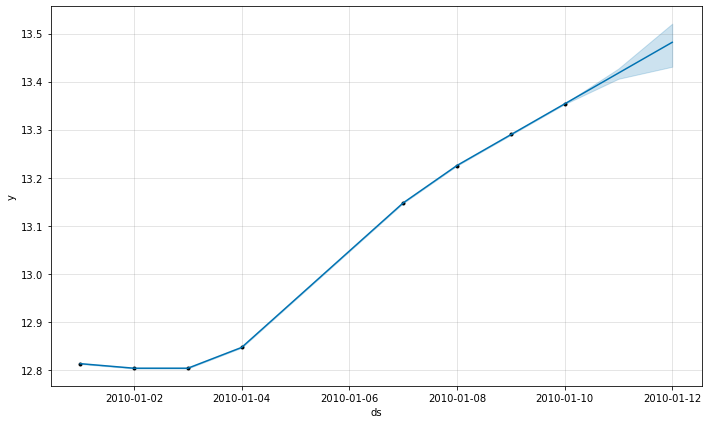

In [14]:
# Load prophet
p = Prophet()
#p.add_seasonality(name='yearly', period=365, fourier_order=2)

# create data-frame to be fited
mydf = pd.DataFrame()

# redefining key (year) as dates, because FB-prophet has hardtime with year cross-validation. Will swtich it later
mydf["ds"] = ["2010-01-01","2010-01-02","2010-01-03","2010-01-04","2010-01-07","2010-01-08","2010-01-09","2010-01-10"]
mydf["y"] = np.log(newdfAVG[2111].values);

# Fit date vs log(tax) using time-series
p.fit(mydf)

# create future dates for forecast and predict
future = p.make_future_dataframe(periods=2,freq='d');
forecast = p.predict(future);

# Plot the forcast
fig1 = p.plot(forecast);
#plt.xticks([2010,2011,2012,2013,2016,2017,2018,2019,2020,2021])

Above is the time series ARIMA prediction of mean-tax-assessment as a function of time. The x-axis numbers are not correct, but the last-point (ds=2010-01-10) is the for 2019, beyond which are predictions with confidence intervals. 

### cross-validation in time and check the error 

INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.


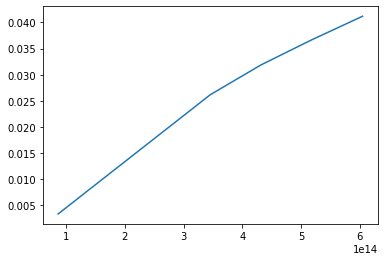

In [7]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# Define time-frame of cross-validation 
df_cv = cross_validation(model = p, 
                         initial = "1 days", 
                         #period  = "365 days",
                         horizon = "7 days")

# calculate all performance metrics 
df_p = performance_metrics(df_cv)

# plot mean absolute percent error (mape) with time 
plt.plot(df_p["horizon"],df_p["mape"])

The cross-validation show mean-percent error less than 4%. 

# Time-series modeling for all zipcodes - 24 different models 

In [18]:
# Unique zipcodes 
ZipCodes = pd.unique(df["ZIPCODE"])
print("there are ", len(ZipCodes), "number of models to be fitted")

there are  29 number of models to be fitted


In [16]:
mydict = {}
mymodel = {}
for Z in ZipCodes:

    # Define prophet for every zipcode
    mymodel[Z] = Prophet(); 
    
    # Gather data for fitting 
    mydf = pd.DataFrame();
    mydf["ds"] = ["2010-01-01","2010-01-02","2010-01-03","2010-01-04","2010-01-07","2010-01-08",
                 "2010-01-09","2010-01-10"];
        #mydf["ds"] = newdfAVG.index.values
        #mydf["ds"] = pd.to_datetime(mydf["ds"], format="%Y")
    mydf["y"] = np.log(newdfAVG[Z].values);
    
    # Create model for this ZipCode
    mymodel[Z].fit(mydf);
    future = mymodel[Z].make_future_dataframe(periods=2,freq='d');
    forecast = mymodel[Z].predict(future);
    
    # Cross-Validation
    df_cv = cross_validation(model = mymodel[Z], 
                             initial = "1 days", 
                             #period  = "365 days",
                             horizon = "7 days");
    df_p = performance_metrics(df_cv); 
    
    # Printing and saving
    print(Z, forecast.iloc[8]["ds"], forecast.iloc[8]["yhat"], df_p.iloc[4]["mape"], df_p.iloc[4]["mae"]); 
    mydict[Z] = forecast.iloc[8];

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2108 2010-01-11 00:00:00 15.395663756087743 0.009981452368784097 0.15306430949266137


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2128 2010-01-11 00:00:00 13.32405758833546 0.05161943191540943 0.681841178568865


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2129 2010-01-11 00:00:00 13.818292540250072 0.03574229905298066 0.4915518636739016


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2114 2010-01-11 00:00:00 14.803926208696828 0.002111171566025363 0.031121705716264714


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2113 2010-01-11 00:00:00 13.959723275362203 0.037887533020074846 0.5263978062478714


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2109 2010-01-11 00:00:00 13.864362992488207 0.03801813093046514 0.5247312187807225


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2111 2010-01-11 00:00:00 13.417877909170494 0.041184803962220046 0.5499461312152345


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2118 2010-01-11 00:00:00 14.826763857566114 0.011506258893418529 0.16978138177736568


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2116 2010-01-11 00:00:00 14.849651152856106 0.004380597146346532 0.06479957846581108


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2115 2010-01-11 00:00:00 14.734829960353183 0.014006136713697522 0.2055708572261974


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2215 2010-01-11 00:00:00 14.6416413321129 0.01806629732848325 0.26362762840172316


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2127 2010-01-11 00:00:00 13.717136947530998 0.0363219913491408 0.4958657017048633


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2125 2010-01-11 00:00:00 13.321196202979056 0.04505457241461998 0.5965867704617587


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2124 2010-01-11 00:00:00 13.152911885060877 0.04195100849763159 0.5493884549756398


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2119 2010-01-11 00:00:00 13.079224063011026 0.04214984536703724 0.549134432227742


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2120 2010-01-11 00:00:00 13.956066023621563 0.02820312563741564 0.39147605913315076


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2130 2010-01-11 00:00:00 13.68274085141173 0.03867958513712041 0.5272596186786824


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2199 2010-01-11 00:00:00 13.896789640242426 0.04220183965369255 0.5849352302524604


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2121 2010-01-11 00:00:00 13.10971609643901 0.04026120698485171 0.5258876894456286


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2126 2010-01-11 00:00:00 12.991796447234854 0.04560751854746149 0.5901594499721323


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2136 2010-01-11 00:00:00 12.954289571739926 0.01447527562373865 0.186844346425044


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2122 2010-01-11 00:00:00 13.247353725563363 0.042251996763594576 0.5567839782589061


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2131 2010-01-11 00:00:00 13.214175028891344 0.035979142128727784 0.4736227493383858


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2132 2010-01-11 00:00:00 13.213253838198723 0.0183237962524707 0.2413702924994876


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2467 2010-01-11 00:00:00 13.306264146532108 0.024531915569818277 0.32571987691710724


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2134 2010-01-11 00:00:00 13.70092869648373 0.04271444624225244 0.5831565701869224


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2135 2010-01-11 00:00:00 13.666211011351491 0.03619141110555198 0.49302340406644696


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


2446 2010-01-11 00:00:00 13.82745240322546 0.035030974301768075 0.4826518809802014


INFO:fbprophet:Making 1 forecasts with cutoffs between 2010-01-03 00:00:00 and 2010-01-03 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 1.


2445 2010-01-11 00:00:00 14.179590170519399 0.033103734995853173 0.4680503177954556


The variable "mymodel[Z]" contains the time-series model for the 29 different 'Z' ZIP-code. I will access these models for forecasting mean-tax-assessment for 2020. 

In [19]:
outputdf_2020Predictions = pd.DataFrame(mydict)
outputdf_2020Predictions

,2108,2128,2129,2114,2113,2109,2111,2118,2116,2115,...,2126,2136,2122,2131,2132,2467,2134,2135,2446,2445
ds,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,...,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00,2010-01-11 00:00:00
trend,15.3957,13.3241,13.8183,14.8039,13.9597,13.8644,13.4179,14.8268,14.8497,14.7348,...,12.9918,12.9543,13.2474,13.2142,13.2133,13.3063,13.7009,13.6662,13.8275,14.1796
yhat_lower,15.3908,13.3048,13.8034,14.7982,13.9515,13.8541,13.4068,14.8154,14.8422,14.7182,...,12.9772,12.9457,13.2325,13.2026,13.2019,13.2969,13.6888,13.6514,13.812,14.1586
yhat_upper,15.3997,13.3376,13.8315,14.8097,13.9697,13.873,13.4272,14.8372,14.857,14.7429,...,13.0045,12.9619,13.2562,13.2243,13.2236,13.3151,13.7132,13.6797,13.8419,14.1978
trend_lower,15.3911,13.305,13.8035,14.7987,13.9513,13.8536,13.4071,14.816,14.8423,14.7186,...,12.9807,12.9457,13.2323,13.2036,13.2064,13.2976,13.6883,13.6514,13.8132,14.1584
trend_upper,15.3999,13.3377,13.8316,14.8097,13.9698,13.8731,13.4271,14.8358,14.8569,14.7427,...,13.0013,12.9619,13.2562,13.223,13.2182,13.3136,13.7133,13.6797,13.8411,14.1975
additive_terms,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
additive_terms_lower,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
additive_terms_upper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
multiplicative_terms,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Save the prediction-data to prevent rerunning!
# pickle.dump(outputdf_2020Predictions,open("2020ZipCodeTax_Predictions.dat",'wb')); 

# Plots - check the predictions! 

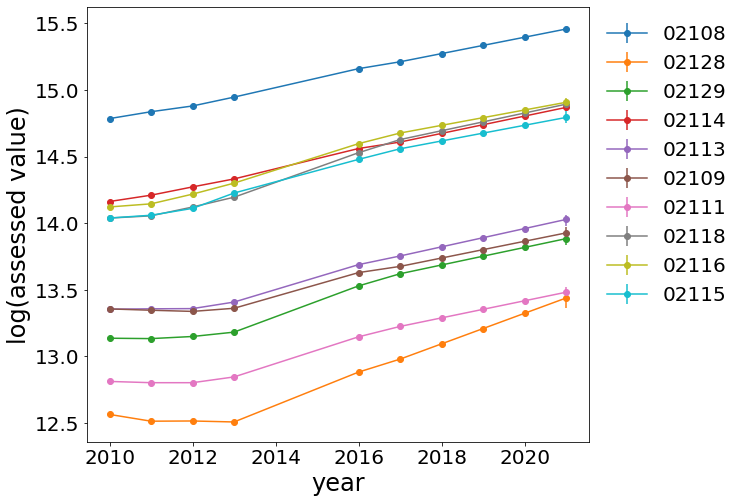

In [22]:
myds = [2010,2011,2012,2013,2016,2017,2018,2019,2020,2021]
fig = plt.figure(figsize=(9,8))
for Z in ZipCodes[0:10]:
    #Z=2108
    future = mymodel[Z].make_future_dataframe(periods=2,freq='d');
    forecast = mymodel[Z].predict(future);
    lowlim = forecast["yhat"] - forecast["yhat_lower"];
    uplim = forecast["yhat_upper"] - forecast["yhat"];
    plt.errorbar(myds,forecast["yhat"], yerr = (lowlim,uplim),marker='o',label="0"+str(Z));

plt.xticks(size=20);
plt.yticks(size=20); 
plt.xlabel("year", size=24);
plt.ylabel("log(assessed value)",size=24); 
plt.legend(prop={'size': 20},frameon=False,bbox_to_anchor=(1.0, 1.0));
plt.savefig("time_series.png",bbox_inches="tight",dpi=300)
plt.show()

Above plot show 2020 and 2021 predictions of mean-tax-assessment per ZIP-code. The output of 2020 predictions will be used as the input of the main model. 